# Glacier dynamics toy model

Toy model based on the Shallow Ice Approximation (SIA), mixing
partial differential equations (PDEs), neural networks and model
interpretation using SINDy.

The equation we are going to use is the Shallow Ice approximation:

$$ \frac{\partial H}{\partial t} = \dot b + \nabla \cdot \left( \left( u_b + \frac{2A}{n+2} H \right) H^{n+1} (\rho g)^n  \, || \nabla S ||^{n-1} \nabla S \right) $$

with 
- $H$ the glacier ice thickness
- $n$ the exponent in Glen's Law
- $A$ the deformation sliding factor in Glen's Law
- $u_b$ is the basal slip velocity 
- $\dot b$ the point mass balance 
- $S$ the surface elevation of the glacier

Assuming that the basal slip velocity is zero and ignoring the mass balance term, the SIA equation is equivalent to the 2D diffusivity equation 

$$ \frac{\partial H}{\partial t} = \nabla \cdot \left( D \, \nabla (B + H) \right) $$

where $B$ is the coordinate of the bed (fixed) and $D$ is a nonlinear diffusivity coefficient given by: 

$$ D (H, \nabla S) = \frac{2A}{n+2}(\rho g)^n H^{n+2} || \nabla S ||^{n-1} $$

### Questions

1) For the real data example, the first steps of the numerical simulation are basically doing some kind of smoothing od the surface elevations. Is there another way of doing this?

In [1]:
## Environment and packages
cd(@__DIR__)
using Pkg; Pkg.activate("."); Pkg.instantiate()
using Infiltrator
#using Debugger

# using Flux, DiffEqFlux, DataDrivenDiffEq
# using Flux: @epochs
# using Zygote
using DifferentialEquations
using ComponentArrays
using PaddedViews
using Parameters: @unpack
using Plots; gr()
using Measures
using Base: @kwdef
using Statistics
using ModelingToolkit
using LinearAlgebra
using HDF5
# Set a random seed for reproduceable behaviour
using Random

  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`


### Global parameters

Which A value should be used? 

In [2]:
# Global parameters
A = 2e-16
# A = 1.3e-24 #2e-16  1 / Pa^3 s
# A *= 60 * 60 * 24 * 365.25 # 1 / Pa^3 yr

ρ = 900 # kg / m^3
g = 9.81 # m / s^2
n = 3

Γ = 2 * A * (ρ * g)^n / (n+2) # 1 / m^3 s

# Parameter that control the stepsize of the numerical method 
# η < 1 is requiered for stability
η = 0.2;

### Types
Types to manage glacier raster data and machine learning hyperparameters

In [3]:
# what is the difference between using @kwdef and using the default constructor?

@kwdef mutable struct Hyperparameters
    batchsize::Int = 500     # batch size
    η::Float64 = 0.1         # learning rate
    epochs::Int = 500        # number of epochs
    use_cuda::Bool = true    # use gpu (if cuda available)
end

mutable struct Glacier
    bed::Array{Float32}    # bedrock height
    thick::Array{Float32}  # ice thickness
    vel::Array{Float32}    # surface velocities
    MB::Array{Float32}     # surface mass balance
end

### Functions 
Some functions to deal with staggered grids

In [4]:
@views avg(A)   = 0.25 * ( A[1:end-1,1:end-1] .+ A[2:end,1:end-1] .+ A[1:end-1,2:end] .+ A[2:end,2:end] )
@views avg_x(A) = 0.5 .* ( A[1:end-1,:] .+ A[2:end,:] )
@views avg_y(A) = 0.5 .* ( A[:,1:end-1] .+ A[:,2:end] )
@views inn(A)   = A[2:end-1,2:end-1];

@views function smooth!(A)
    A[2:end-1,2:end-1] .= A[2:end-1,2:end-1] .+ 1.0./4.1.*(diff(diff(A[:,2:end-1], dims=1), dims=1) .+ diff(diff(A[2:end-1,:], dims=2), dims=2))
    A[1,:]=A[2,:]; A[end,:]=A[end-1,:]; A[:,1]=A[:,2]; A[:,end]=A[:,end-1]
    return
end

function void2nan!(x, void)
    for i in eachindex(x)
        @inbounds x[i] = ifelse(x[i]==void, NaN, x[i])
    end
end


void2nan! (generic function with 1 method)

### Load the data
We use simulations from Harry's SIA model as a ground truth dataset to perform some tests.

- Lat/Lon coordinates will later on be available (from the `Glacier directory` in OGGM). 

In [5]:
# Load the HDF5 file with Harry's simulated data
root_dir = pwd()
argentiere_f = h5open(joinpath(root_dir, "data/Argentiere_2003-2100_aflow2e-16_50mres_v2.h5"), "r")

🗂️ HDF5.File: (read-only) /Users/Bolib001/Desktop/Jordi/Julia/odinn_toy_model/data/Argentiere_2003-2100_aflow2e-16_50mres_v2.h5
├─ 🔢 bed
├─ 🔢 s_apply_hist
├─ 🔢 thick_hist
└─ 🔢 vel_hist

In [6]:
# Fill the Glacier structure with the retrieved data
argentiere = Glacier(HDF5.read(argentiere_f["bed"])[begin:end-2,:],
                     HDF5.read(argentiere_f["thick_hist"])[begin:end-2,:,2:end],
                     HDF5.read(argentiere_f["vel_hist"])[begin:end-2,:,2:end],
                     HDF5.read(argentiere_f["s_apply_hist"])[begin:end-2,:,2:end])

# Update mass balance data with NaNs
void2nan!(argentiere.MB, argentiere.MB[1,1,1])

# Domain size
nx = size(argentiere.bed)[1]
ny = size(argentiere.bed)[2];

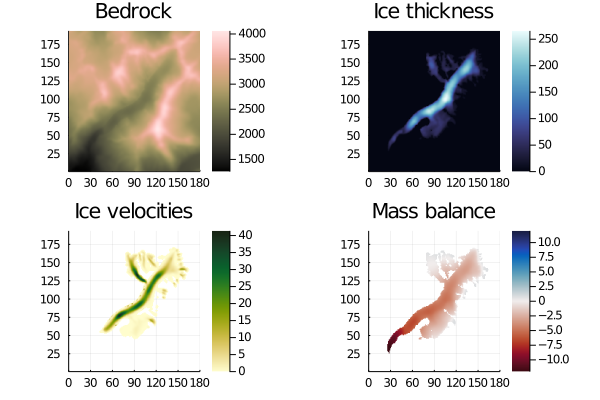

In [19]:
# Argentière bedrock
hm01 = heatmap(argentiere.bed, c = :turku, title="Bedrock")
# Argentière ice thickness for an individual year
hm02 = heatmap(argentiere.thick[:,:,1], c = :ice, title="Ice thickness")
# Surface velocities
hm03 = heatmap(argentiere.vel[:,:,15], c =:speed, title="Ice velocities")
hm04 = heatmap(argentiere.MB[:,:,90], c = cgrad(:balance,rev=true), clim=(-12,12), title="Mass balance")
hm0 = plot(hm01,hm02,hm03,hm04, layout=4, aspect_ratio=:equal, xlims=(0,180))
display(hm0)

There are two examples we can run:

   - Using the real data for the Argèntiere glacier
   - Using simulated data for which we have the exact solution of the SIA equation in order to test our numerical method.

In [8]:
example = "Argentiere"
#example = "Gaussian" # Fake

if example == "Argentiere"
    
    B  = copy(argentiere.bed)
    H₀ = copy(argentiere.thick[:,:,1])
 
    # Spatial and temporal differentials
    Δx = Δy = 50 #m (Δx = Δy)
    
elseif example == "Gaussian"
    
    B = zeros(Float64, (nx, ny))
    σ = 1000
    H₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / σ ) for i in 1:nx, j in 1:ny ]    
    
    # Spatial and temporal differentials
    Δx = Δy = 50 #m (Δx = Δy)
    
end

50

In [9]:
# Grid initialization
dSdx    = zeros(nx-1, ny  )
dSdy    = zeros(nx  , ny-1)
∇S      = zeros(nx-1, ny-1)
D       = zeros(nx-1, ny-1)
Fx      = zeros(nx-1, ny-2)
Fy      = zeros(nx-2, ny-1)
F       = zeros(nx-2, ny-2)
dHdt    = zeros(nx-2, ny-2)
MB      = zeros(nx, ny);


# Dynamical Ice thickness
H = copy(H₀)
# Time 
t = 0
Δts = []
t₁ = 10

10

## Solving the Shallow Ice Approximation

We have two different ways to solve the PDE:


In [10]:
### Choose method to solve the PDE
method = "solver"
#method = "manual"

"solver"

### 1. Solving the ice flow dynamics using an available solver in DifferentialEquations.jl

In [15]:
# Function wrapping the SIA implementation
function iceflow!(dH,H,p,t)

    # Retrieve input variables                    
    Δx, Δy, Γ, B, MB, t_array = p
    
    # Update glacier surface altimetry
    H .= max.(0.0, H) # Avoid negative ice thickness
    S = B .+ H        # Recompute surface altimetry

    # All grid variables computed in a staggered grid
    # Compute surface gradients on edges
    dSdx  .= diff(S, dims=1)/Δx
    dSdy  .= diff(S, dims=2)/Δy
    ∇S .= sqrt.(avg_y(dSdx).^2 .+ avg_x(dSdy).^2)  # gradient norm
    
    # Compute diffusivity on secondary nodes
    D .= Γ * avg(H).^(n+2) .* ∇S.^(n-1)

    # Compute flux components
    dSdx_edges = diff(S[:,2:end-1], dims=1)/Δx
    dSdy_edges = diff(S[2:end-1,:], dims=2)/Δy
    Fx .= .-avg_y(D).*dSdx_edges
    Fy .= .-avg_x(D).*dSdy_edges
    # Flux divergence
    # Zero padding in order to match original grid size
    F_pad = PaddedView(0, .-(diff(Fx, dims=1)/Δx .+ diff(Fy, dims=2)/Δy), size(H), (2,2))
    
    # Retrieve annual mass balance
    timestep = 0.005 # TODO: we should find a way to automatically adjust this value
    if((t%1 <= timestep/2) && !(convert(UInt8, round(t, digits=1)) in t_array))
        #println(t)
        MB_t = MB[:,:, convert(UInt8, round(t, digits=1))]
        MB_max = maximum(filter(!isnan,MB_t)) # filter out NaNs
        MB_min = minimum(filter(!isnan,MB_t))
        println("Adding mass balance (MB max = $MB_max / MB_min = $MB_min) for the year ", convert(UInt8, round(t, digits=1)))
        push!(t_array, convert(UInt8, round(t, digits=1)))
        println("t_array: ", t_array)
        #println("MB_t: ", MB_t)
    else
        MB_t = zeros(size(F_pad))

    dH .= F_pad + MB_t
    end
             
end

iceflow! (generic function with 1 method)

In [16]:
if(method == "solver")

    # Now we solve the PDE using a DifferentialEquations.jl solver
    # Initial parameters
    #smooth!(H₀) # this should not be necessary, to be removed
    t_array = [0]
    p = (Δx, Δy, Γ, B, argentiere.MB, t_array) # Spatial differentials, driving stress, bedrock, mass balance
    u₀ = H₀
    tspan = (0.0, t₁)

    println("Solving PDE...\n")
    # Create ODE problem based on the SIA
    SIA_prob = ODEProblem(iceflow!, u₀, tspan, p)
    # Solve the SIA 
    #SIA_sol = solve(SIA_prob, Euler(), dt = 0.001 )#CVODE_BDF())#,alg_hints = [:stiff])
    SIA_sol = solve(SIA_prob, Tsit5(),save_everystep=false, alg_hints=[:stiff],reltol=1e-7,abstol=1e-7) # TODO: this should be optimized
   
    H = SIA_sol.u[end];
    
end

Solving PDE...

Adding mass balance (MB max = 0.76171875 / MB_min = -13.5) for the year 1
t_array: [0, 1]
Adding mass balance (MB max = 0.76171875 / MB_min = -13.5) for the year 2
t_array: [0, 1, 2]
Adding mass balance (MB max = 0.76171875 / MB_min = -13.5) for the year 3
t_array: [0, 1, 2, 3]
Adding mass balance (MB max = 0.76171875 / MB_min = -13.5) for the year 4
t_array: [0, 1, 2, 3, 4]
Adding mass balance (MB max = 0.76171875 / MB_min = -13.5) for the year 5
t_array: [0, 1, 2, 3, 4, 5]
Adding mass balance (MB max = 0.76171875 / MB_min = -13.5) for the year 6
t_array: [0, 1, 2, 3, 4, 5, 6]
Adding mass balance (MB max = 0.76171875 / MB_min = -13.5) for the year 7
t_array: [0, 1, 2, 3, 4, 5, 6, 7]
Adding mass balance (MB max = 0.76171875 / MB_min = -13.5) for the year 8
t_array: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Adding mass balance (MB max = 0.76171875 / MB_min = -13.5) for the year 9
t_array: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Adding mass balance (MB max = 0.76171875 / MB_min = -13.5) for the

193×189 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

### 2. Solving the glacier ice dynamics manually with an explicit forward scheme

In [47]:
if(method == "manual")
    # Manual explicit forward scheme implementation
    while t < t₁

        # Update glacier surface altimetry
        S = B .+ H

        # All grid variables computed in a staggered grid
        # Compute surface gradients on edges
        dSdx  .= diff(S, dims=1) / Δx
        dSdy  .= diff(S, dims=2) / Δy
        ∇S .= sqrt.(avg_y(dSdx).^2 .+ avg_x(dSdy).^2)

        # Compute diffusivity on secondary nodes
        D .= Γ * avg(H).^(n + 2) .* ∇S.^(n - 1)

        # Compute flux components
        dSdx_edges = diff(S[:,2:end - 1], dims=1) / Δx
        dSdy_edges = diff(S[2:end - 1,:], dims=2) / Δy
        Fx .= .-avg_y(D) .* dSdx_edges
        Fy .= .-avg_x(D) .* dSdy_edges
        #  Flux divergence
        F .= .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) # MB to be added here 
            
        # Compute the maximum diffusivity in order to pick a temporal step that garantees estability 
        D_max = maximum(D)
        Δt = η * ( Δx^2 / (2 * D_max ))
        append!(Δts, Δt)

        #  Update the glacier ice thickness
        dHdt = F .* Δt   
        global H[2:end - 1,2:end - 1] .= max.(0.0, inn(H) .+ dHdt)
        
        t += Δt
        # println("time: ", t)
        
    end 
end

### Plot the glacier evolution

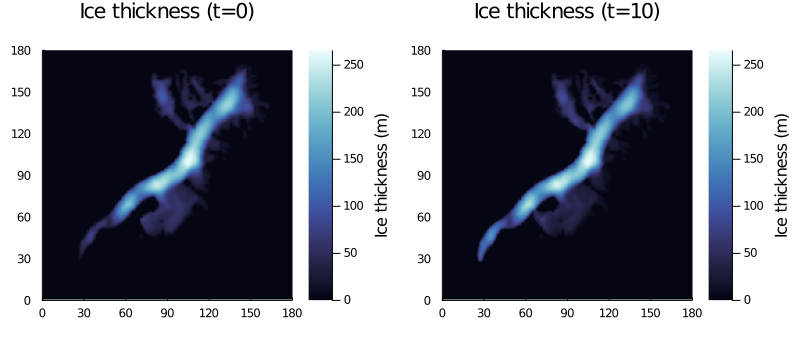

In [38]:
hm11 = heatmap(H₀, c = :ice, title="Ice thickness (t=0)")
hm12 = heatmap(H, c = :ice, title="Ice thickness (t=$t₁)")
hm1 = plot(hm11,hm12, layout=2, aspect_ratio=:equal, size=(800,350), xlims=(0,180), ylims=(0,180), colorbar_title="Ice thickness (m)", clims=(0,maximum(H₀)), link=:all)

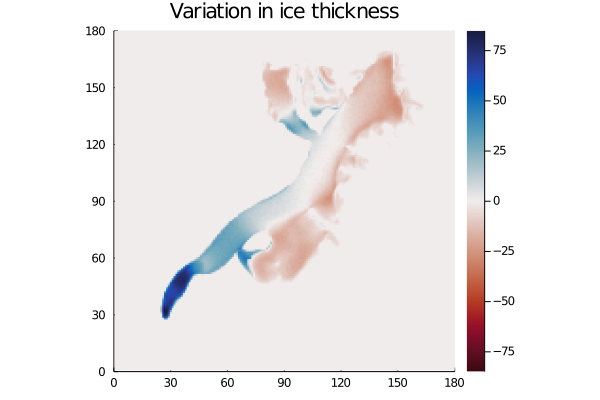

In [39]:
lim = maximum( abs.(H .- H₀) )

hm02 = heatmap(H .- H₀, c = cgrad(:balance,rev=true), aspect_ratio=:equal, xlims=(0,180), ylims=(0,180), clim = (-lim, lim), title="Variation in ice thickness")

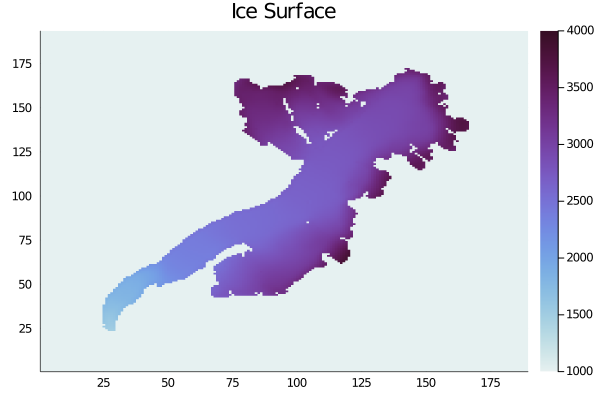

In [50]:
indicator(x) = if x>0; 1; else; 0; end
S₊ = indicator.(H) .* (B + H);

heatmap(S₊, c = :dense, clim = (1000, 4000), title = "Ice Surface" )

In [51]:
using Plots; pyplot()
x=1:nx
y=1:ny
f₀(x,y) = H₀[x,y]
f(x,y) = H[x,y]
plot(x,y,f₀,st=:surface,c=cgrad(:algae),camera=(-30,30), fillalpha = 1)
plot!(x,y,f,st=:surface,c=cgrad(:amp),camera=(-30,30), fillalpha = 1)

LoadError: ArgumentError: Package PyPlot not found in current path:
- Run `import Pkg; Pkg.add("PyPlot")` to install the PyPlot package.


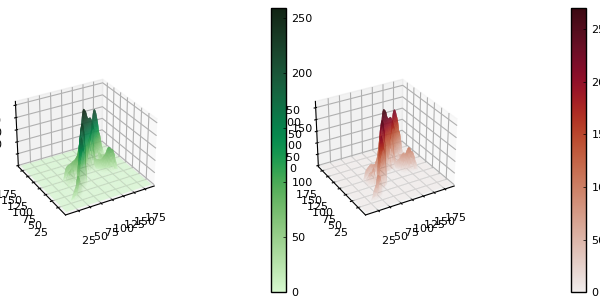

In [ ]:
hm01 = plot(x,y,f₀,st=:surface,c=cgrad(:algae),camera=(-30,30), fillalpha = 1)
hm02 = plot(x,y,f,st=:surface,c=cgrad(:amp),camera=(-30,30), fillalpha = 1)
hm0 = plot(hm01,hm02, layout=(1,2), size=(600,300) )
#display(hm0)

We can plot the $\Delta t$ use in the adaptive method as a function of the iterations:

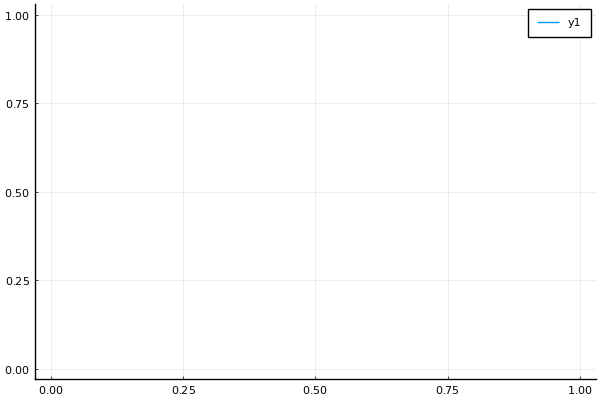

In [ ]:
plot(Δts)